# **Physics-informed neural networks (PINNs)**
## **Tutorial part 2: PINNs scope of use**
#### **Thi Nguyen Khoa Nguyen, Thibault Dairay, Raphaël Meunier, Christophe Millet, and Mathilde Mougeot**

The objective of this practical session is to understand how to use PINNs to solve different types of problems involving partial differential equation (PDE) or system of PDEs.

#### Loading package

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from math import *
import tensorflow as tf
import sys

import scipy

tf.keras.backend.set_floatx('float64')
tf.get_logger().setLevel('ERROR')

colab = "/content" in os.getcwd()
if colab:
    # clone github repository
    !git clone https://github.com/nguyenkhoa0209/pinns_tutorial
    %cd /content/pinns_tutorial/
    from pinns import PINNs
else:
    !git clone https://github.com/nguyenkhoa0209/pinns_tutorial
    from pinns_tutorial.pinns import PINNs

Cloning into 'pinns_tutorial'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 15 (delta 0), reused 9 (delta 0), pack-reused 0
Receiving objects: 100% (15/15), 39.63 MiB | 15.77 MiB/s, done.
/content/pinns_tutorial


## Table of content:
1. [Introduction to vanilla PINNs](#1-bullet)
    * [Example: Viscid Burgers equation](#1.1-bullet)
    * [Exercise: Inviscid Burgers equation](#1.2-bullet)
2. [Inverse problem](#2-bullet)
    * [Example: Burgers equation](#2.1-bullet)
    * [Exercise: Linear elascity](#2.2-bullet)
3. [Ill-posed problem](#3-bullet)
    * [Example: Navier-Stokes equations](#3.1-bullet)
4. [Generalization problem](#4-bullet)
    * [Example: Burgers equation](#1.1-bullet)
    * [Exercise: Wave equation](#1.2-bullet)

## 1. Introduction to vanilla PINNs <a name="1-bullet"></a>

First, let us recall the general formulation of the vanilla PINNs. Considering the following parameterized PDE defined on the domain $\Omega \subset \mathbb{R}^d$ with the boundary $\partial\Omega$:
\begin{align}
&\partial_t \boldsymbol{u} + \mathcal{N}_\boldsymbol{\mathrm{x}}(\boldsymbol{u}, \lambda)=0, \text{ for } \boldsymbol{\mathrm{x}}\in\Omega, t\in[0,T]\\
&\boldsymbol{u}(\boldsymbol{\mathrm{x}},0)=g(\boldsymbol{\mathrm{x}}), \text{ for } \boldsymbol{\mathrm{x}}\in\Omega\\
&\mathcal{B}(\boldsymbol{u},\boldsymbol{\mathrm{x}},t)=0, \text{ for } \boldsymbol{\mathrm{x}}\in\partial\Omega\\
\end{align}
where $\boldsymbol{\mathrm{x}} \in \mathbb{R}^d$ and $t$ are the spatial and temporal coordinates, $\mathcal{N}_{\boldsymbol{\mathrm{x}}}$ is a differential operator, $\boldsymbol{\lambda}$ is the PDE parameter, $\boldsymbol{u}$ is the solution of the PDE with initial condition $g(\boldsymbol{\mathrm{x}})$ and boundary condition $\mathcal{B}$, which could be Dirichlet, Neumann, Robin, or periodic boundary conditions. The subscripts denote the partial differentiation in time or space. In PINNs, the solution $\boldsymbol{u}$ of the PDE is approximated by a fully-connected feedforward neural network $\mathcal{NN}$:
\begin{align*}
    \boldsymbol{u} \approx \hat{\boldsymbol{u}} = \mathcal{NN}(\boldsymbol{\mathrm{x}}, t, \boldsymbol{\theta})
\end{align*}
where $\hat{\boldsymbol{u}}$ denotes the prediction value for the solution and $\boldsymbol{\theta}$ denotes the trainable parameters of the neural network. The parameters of the neural network are trained by minimizing the cost function $L$:
\begin{align}
    L = L_{pde} + L_{ic} + L_{bc} + L_{data}
\end{align}
where the terms $L_{pde},L_{ic},L_{bc}$ and $L_{data}$ penalize the loss in the residual of the PDE, the initial condition, the boundary condition, and the supervised data (measurements), respectively, which can be represented as follow:
\begin{align*}
    L_{pde} &= \dfrac{1}{N_{pde}}\sum_{i=1}^{N_{pde}}|\hat{\boldsymbol{u}}_{t^i} + \mathcal{N}_{\boldsymbol{\mathrm{x}}^{i}}(\hat{\boldsymbol{u}^{i}}, \boldsymbol{\lambda})|^2\\
    L_{ic} &= \dfrac{w_{ic}}{N_{ic}}\sum_{i=1}^{N_{ic}}|\boldsymbol{\hat{u}}(\boldsymbol{\mathrm{x}}^i,0) - g(\boldsymbol{\mathrm{x}}^i)|^2\\
    L_{bc} &= \dfrac{w_{bc}}{N_{bc}}\sum_{i=1}^{N_{bc}}|\mathcal{B}(\hat{\boldsymbol{u}^i}, \boldsymbol{\mathrm{x}}^{i}, t^{i})|^2\\
    L_{data} &= \dfrac{w_{data}}{N_{data}}\sum_{i=1}^{N_{data}}|\hat{\boldsymbol{u}}(\boldsymbol{\mathrm{x}}^i,t^i) - \boldsymbol{u}(\boldsymbol{\mathrm{x}}^i,t^i)|^2\\
\end{align*}
where $w_{ic}, w_{bc}, w_{data}$ are the weights to balance different terms in the cost function.

The definition of the cost function $L$ and the trainable parameters depend on the problems:

|Type of problem | Input of $\mathcal{NN}$ | Trainable parameter | Loss function |
| :- | -: | -: |-: |
| Forward | $(\boldsymbol{\mathrm{x}},t)$ | $\theta$ | $L = L_{pde} + L_{ic} + L_{bc}$
| Inverse | $(\boldsymbol{\mathrm{x}},t)$ | $\theta,\lambda$ | $L = L_{pde} + L_{data}$
| Ill-posed | $(\boldsymbol{\mathrm{x}},t)$ | $\theta$ | $L = L_{pde} + L_{data}$
| Generalization | $(\boldsymbol{\mathrm{x}},t,\lambda)$ | $\theta$ | $L = L_{pde} + L_{ic} + L_{bc}$


## Forward problem
In forward problems, the initial and/or boundary conditions (IC and/or BCs) of the PDEs are well-defined. The measurements of the solutions (supervised data) are optional. We aim to infer the solution in the entire domain using PINNs.

To solve a PDE problem, there exists two equivalent formulations: the strong form and the weak form.
* The strong form consists of the differential equations along with IC and BCs. It imposes continuity and differentiability requirements on the potential solutions to the equation.
* The weak form is an alternative representation of the differential equations, which relaxes the continuity and differentiability requirements. It reduces the order of the derivatives and forces the solution to satisfied an integral functions.

### Example: Viscid Burgers equation <a name="1.1-bullet"></a>
We consider the following viscid Burgers equation:
\begin{align}
  &u_t + uu_x -\nu u_{xx} = 0 \quad \text{for } x\in [-1,1], t\in[0, 1] \\
  &u(x,0) = -\sin(\pi x) \quad \text{for } x\in [-1,1]\\
  &u(-1,t) = u(1,t) = 0 \quad \text{for } t\in [0,1]
\end{align}
where $\nu$ is the PDE parameter. In this section, we take $\nu=0.025$.

We denote $\hat{u}=\mathcal{NN}(\boldsymbol{\mathrm{x}}, t, \boldsymbol{\theta})$ the prediction of PINNs for the solution. The loss function, which includes the loss the IC/BC and the PDE residuals, now becomes:
\begin{align}
  L &= L_{pde} + L_{ic} + L_{bc}\\
    &= \dfrac{1}{N_{pde}}\sum_{i=1}^{N_{pde}}|\hat{u}^i_{t} + \hat{u}^i\hat{u}^i_{x}-\nu \hat{u}_{xx}|^2 + \dfrac{w_{ic}}{N_{ic}}\sum_{i=1}^{N_{ic}}|\hat{u}(x^i,0) + \sin(\pi x^i)|^2 + \dfrac{w_{bc}}{N_{bc}}\sum_{i=1}^{N_{bc}}(|\hat{u}(-1,t^i)|^2+|\hat{u}(1,t^i)|^2)
\end{align}
Here we will take $w_{ic}=w_{bc}=1$.

We take the following steps to train PINNs:
* Define the domain
* Define the initial/boundary conditions (IC/BC) and the training points
* Define PDE residuals and loss term for the PDE
* Define PINNs architecture
* Train PINNs

#### Define the domain

In [2]:
# Define the domain

nx = 256
nt = 100
x = np.linspace(-1, 1, nx)
t = np.linspace(0, 1, nt)
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

#### Define the IC/BC, training points, and PDE parameters

In [3]:
# Define the IC
idx_init = np.where(X_star[:, 1]==0)[0]
X_init = X_star[idx_init]
u_init = -np.sin(pi*X_init[:, 0:1])

# Define the BC:
idx_bc = np.where((X_star[:, 0]==1.0)|(X_star[:, 0]==-1.0))[0]
X_bc = X_star[idx_bc]
u_bc = np.zeros((X_bc.shape[0], 1))

# Define training collocation points
N_f = 2000
idx_Xf = np.random.choice(X_star.shape[0], N_f, replace=False)
X_colloc_train = X_star[idx_Xf]

# Define the PDE parameter
nu = 0.025

#### Define PDE residuals and loss term for the PDE

In [4]:
def net_transform(X_f, model_nn):
    return model_nn(X_f)

def f_user(X_f, model_nn):
    x_temp = X_f[:, 0:1]
    t_temp = X_f[:, 1:2]
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x_temp)
        tape.watch(t_temp)
        X_temp = tf.concat([x_temp, t_temp], axis=1)

        u = net_transform(X_temp, model_nn)

        u_x = tape.gradient(u, x_temp)
        u_xx = tape.gradient(u_x, x_temp)
        u_t = tape.gradient(u, t_temp)

    f = u_t + u*u_x - nu*u_xx
    return f

def loss_f(f):
    return tf.reduce_mean(tf.square(f))

#### Define PINNs architecture

In [5]:
# Depth and width of the neural networks
layers = [2] + [50]*4 + [1]

# Learning rate for Adam optimizer
lr = 0.001

#### Train PINNs

In [6]:
model_classic = PINNs(X_colloc_train, net_transform, f_user, loss_f,
                          layers, lr,type_problem='forward', X_bc = X_bc, u_bc = u_bc, X_init = X_init, u_init = u_init)

model_classic.train(max_epochs_adam=0, max_epochs_lbfgs=2000, print_per_epochs=100)

No data inside the domain
No other condition is provided
No data for testing
Loss pinns at epoch 0 (L-BFGS): 0.42532533526829064
Loss pinns at epoch 100 (L-BFGS): 0.047657954895116886
Loss pinns at epoch 200 (L-BFGS): 0.005788610011082538
Loss pinns at epoch 300 (L-BFGS): 0.0010850017405880808
Loss pinns at epoch 400 (L-BFGS): 0.0003589421334818688
Loss pinns at epoch 500 (L-BFGS): 0.0001945124600851972
Loss pinns at epoch 600 (L-BFGS): 0.00010503220781093596
Loss pinns at epoch 700 (L-BFGS): 6.22464058829408e-05
Loss pinns at epoch 800 (L-BFGS): 4.467567764060547e-05
Loss pinns at epoch 900 (L-BFGS): 3.2793230421249026e-05
Loss pinns at epoch 1000 (L-BFGS): 2.4542440026543167e-05
Loss pinns at epoch 1100 (L-BFGS): 1.8620601064724263e-05
Loss pinns at epoch 1200 (L-BFGS): 1.5713429371131457e-05
Loss pinns at epoch 1300 (L-BFGS): 1.3324367254059488e-05
Loss pinns at epoch 1400 (L-BFGS): 1.1402039882882763e-05
Loss pinns at epoch 1500 (L-BFGS): 9.942720328322771e-06
Loss pinns at epoch 1

#### Visualize the results

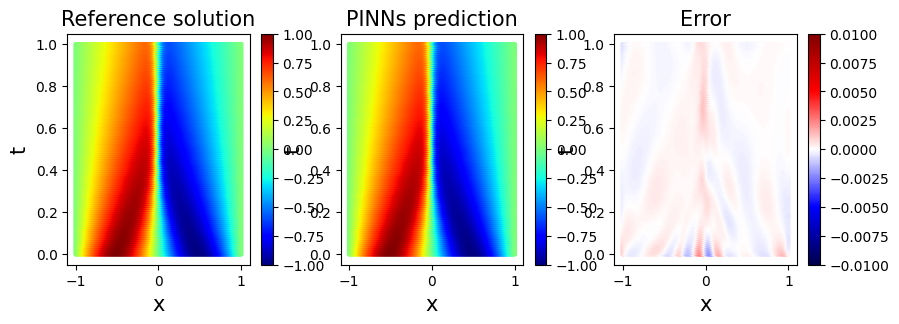

In [7]:
pred = model_classic.net_transform(tf.convert_to_tensor(X_star, dtype='float64'), model_classic.net_u)

u_star_array = np.load('./data/burgers_sol.npy', allow_pickle=True)
u_star = u_star_array[-1]

fig = plt.figure(figsize=[10,3])
axes = fig.subplots(1,3, sharex=False, sharey=False)
img1 = axes[0].scatter(X_star[:, 0:1], X_star[:, 1:2], c=u_star, cmap='jet', vmax=1, vmin=-1, s=5)
axes[0].set_title('Reference solution', fontsize=15)
axes[0].set_xlabel('x', fontsize=15)
axes[0].set_ylabel('t', fontsize=15)
plt.colorbar(img1, ax=axes[0])
img2 = axes[1].scatter(X_star[:, 0:1], X_star[:, 1:2], c=pred, cmap='jet', vmax=1, vmin=-1, s=5)
axes[1].set_title('PINNs prediction', fontsize=15)
axes[1].set_xlabel('x', fontsize=15)
axes[1].set_ylabel('t', fontsize=15)
plt.colorbar(img2, ax=axes[1])
img3 = axes[2].scatter(X_star[:, 0:1], X_star[:, 1:2], c=u_star-pred, cmap='seismic', vmax=0.01, vmin=-0.01, s=5)
axes[2].set_title('Error', fontsize=15)
axes[2].set_xlabel('x', fontsize=15)
axes[2].set_ylabel('t', fontsize=15)
plt.colorbar(img3, ax=axes[2])

#### Visualize the cost function

Text(0.5, 1.0, 'Cost function')

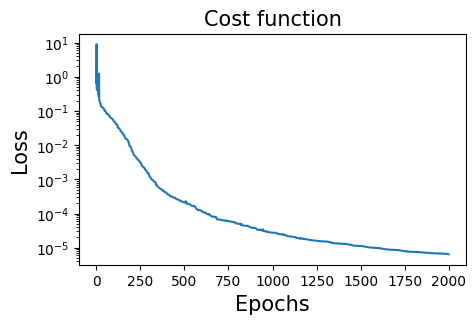

In [8]:
fig = plt.figure(figsize=[5,3])
plt.semilogy(model_classic.loss_array)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.title('Cost function', fontsize=15)

### Forcing hardly the IC/BC to increase the performance

We note that we can force the IC/BC to be automatically satisfied. Instead of imposing the prediction $\hat{\boldsymbol{u}} = \mathcal{NN}(\boldsymbol{\mathrm{x}}, t, \boldsymbol{\theta})$, we can use the following representation:
$$\hat{\boldsymbol{u}} = t(x-1)(x+1) \mathcal{NN}(\boldsymbol{\mathrm{x}}, t, \boldsymbol{\theta}) - \sin(\pi x)$$
We can do this by modified the **net_transform** function in PINNs.

In [9]:
def net_transform(X_f, model_nn):
    x_f = X_f[:, 0:1]
    t_f = X_f[:, 1:2]
    return model_nn(X_f)*t_f*(x_f+1)*(x_f-1) - tf.math.sin(pi*x_f)

In [10]:
def net_transform(X_f, model_nn):
    #return model_nn(X_f) ##if forcing no transform for the networks' output
    return model_nn(X_f)*X_f[:, 1:2]*(X_f[:, 0:1]+1)*(X_f[:, 0:1]-1) - tf.math.sin(pi*X_f[:, 0:1])

def f_user(X_f, model_nn):
    x_temp = X_f[:, 0:1]
    t_temp = X_f[:, 1:2]
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x_temp)
        tape.watch(t_temp)
        X_temp = tf.concat([x_temp, t_temp], axis=1)

        u = net_transform(X_temp, model_nn)

        u_x = tape.gradient(u, x_temp)
        u_xx = tape.gradient(u_x, x_temp)
        u_t = tape.gradient(u, t_temp)

    f = u_t + u*u_x - nu*u_xx
    return f

def loss_f(f):
    return tf.reduce_mean(tf.square(f))

#### Train PINNs

In [11]:
model_classic = PINNs(X_colloc_train, net_transform, f_user, loss_f,
                          layers, lr,type_problem='forward')

model_classic.train(max_epochs_adam=0, max_epochs_lbfgs=2000, print_per_epochs=100)

No data on the boundary
No data at the initial instant
No data inside the domain
No other condition is provided
No data for testing
Loss pinns at epoch 0 (L-BFGS): 0.7756093039880924
Loss pinns at epoch 100 (L-BFGS): 0.08017210250676171
Loss pinns at epoch 200 (L-BFGS): 0.008350082535967055
Loss pinns at epoch 300 (L-BFGS): 0.001936165316602685
Loss pinns at epoch 400 (L-BFGS): 0.0007577814143646562
Loss pinns at epoch 500 (L-BFGS): 0.00029279750939381594
Loss pinns at epoch 600 (L-BFGS): 0.00017772754017754733
Loss pinns at epoch 700 (L-BFGS): 0.00012321844668347588
Loss pinns at epoch 800 (L-BFGS): 8.579244287678025e-05
Loss pinns at epoch 900 (L-BFGS): 5.9040228104261056e-05
Loss pinns at epoch 1000 (L-BFGS): 4.691969738699339e-05
Loss pinns at epoch 1100 (L-BFGS): 3.8401828363293345e-05
Loss pinns at epoch 1200 (L-BFGS): 3.179448623624587e-05
Loss pinns at epoch 1300 (L-BFGS): 2.675243880294144e-05
Loss pinns at epoch 1400 (L-BFGS): 2.1378741346016023e-05
Loss pinns at epoch 1500 (

#### Visualize the results

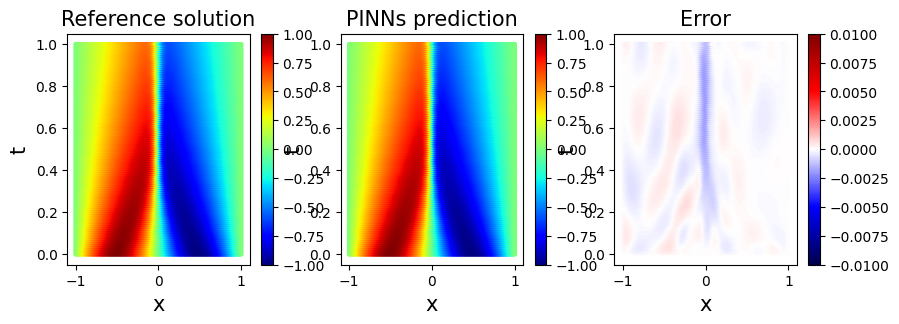

In [12]:
pred = model_classic.net_transform(tf.convert_to_tensor(X_star, dtype='float64'), model_classic.net_u)

fig = plt.figure(figsize=[10,3])
axes = fig.subplots(1,3, sharex=False, sharey=False)
img1 = axes[0].scatter(X_star[:, 0:1], X_star[:, 1:2], c=u_star, cmap='jet', vmax=1, vmin=-1, s=5)
axes[0].set_title('Reference solution', fontsize=15)
axes[0].set_xlabel('x', fontsize=15)
axes[0].set_ylabel('t', fontsize=15)
plt.colorbar(img1, ax=axes[0])
img2 = axes[1].scatter(X_star[:, 0:1], X_star[:, 1:2], c=pred, cmap='jet', vmax=1, vmin=-1, s=5)
axes[1].set_title('PINNs prediction', fontsize=15)
axes[1].set_xlabel('x', fontsize=15)
axes[1].set_ylabel('t', fontsize=15)
plt.colorbar(img2, ax=axes[1])
img3 = axes[2].scatter(X_star[:, 0:1], X_star[:, 1:2], c=u_star-pred, cmap='seismic', vmax=0.01, vmin=-0.01, s=5)
axes[2].set_title('Error', fontsize=15)
axes[2].set_xlabel('x', fontsize=15)
axes[2].set_ylabel('t', fontsize=15)
plt.colorbar(img3, ax=axes[2])

### <font color='red'>**Exercise:** </font> Inviscid Burgers equation <a name="1.2-bullet"></a>
We consider the following inviscid Burgers equation:
\begin{align}
  &u_t + uu_x = 0 \quad \text{for } x\in [-1,1], t\in[0, 1] \\
  &u(x,0) = -\sin(\pi x) \quad \text{for } x\in [-1,1]\\
  &u(-1,t) = u(1,t) = 0 \quad \text{for } t\in [0,1]
\end{align}


#### <font color='red'>**Exercise:** </font> Define the domain

In [ ]:
## TO IMPLEMENT

X_star = ... ## TO IMPLEMENT

In [ ]:
```{toggle}
# Define the domain

nx = 256
nt = 100
x = np.linspace(-1, 1, nx)
t = np.linspace(0, 1, nt)
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
```

#### Define the IC/BC and the training points

In [ ]:
# Define the IC
idx_init = np.where(X_star[:, 1]==0)[0]
X_init = X_star[idx_init]
u_init = -np.sin(pi*X_init[:, 0:1])

# Define the BC:
idx_bc = np.where((X_star[:, 0]==1.0)|(X_star[:, 0]==-1.0))[0]
X_bc = X_star[idx_bc]
u_bc = np.zeros((X_bc.shape[0], 1))

# Define training collocation points
N_f = 2000
idx_Xf = np.random.choice(X_star.shape[0], N_f, replace=False)
X_colloc_train = X_star[idx_Xf]

# Define the PDE parameter
nu = 0.025

#### <font color='red'>**Exercise:** </font> Define PDE residuals and loss term for the PDE

In [ ]:
def net_transform(X_f, model_nn):
    ## TO IMPLEMENT
    return ...

def f_user(X_f, model_nn):
    x_temp = X_f[:, 0:1]
    t_temp = X_f[:, 1:2]
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x_temp)
        tape.watch(t_temp)
        X_temp = tf.concat([x_temp, t_temp], axis=1)

        u = net_transform(X_temp, model_nn)

        ## TO IMPLEMENT

    return ...

def loss_f(f):
    ## TO IMPLEMENT
    return ...

In [ ]:
```{toggle}
def net_transform(X_f, model_nn):
    return model_nn(X_f)

def f_user(X_f, model_nn):
    x_temp = X_f[:, 0:1]
    t_temp = X_f[:, 1:2]
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x_temp)
        tape.watch(t_temp)
        X_temp = tf.concat([x_temp, t_temp], axis=1)

        u = net_transform(X_temp, model_nn)

        u_x = tape.gradient(u, x_temp)
        u_t = tape.gradient(u, t_temp)

    f = u_t + u * u_x
    return f

def loss_f(f):
    return tf.reduce_mean(tf.square(f))
```

#### <font color='red'>**Exercise:** </font> Define PINNs architecture

In [ ]:
# Depth and width of the neural networks
layers = ## TO IMPLEMENT

# Learning rate for Adam optimizer
lr =  ## TO IMPLEMENT

In [ ]:
```{toggle}
# Depth and width of the neural networks
layers = [2] + [50]*4 + [1]

# Learning rate for Adam optimizer
lr = 0.001
```

#### <font color='red'>**Exercise:** </font> Train PINNs

In [ ]:
model_classic = PINNs(...) ## TO IMPLEMENT
model_classic.train(max_epochs_adam=..., max_epochs_lbfgs=..., print_per_epochs=100) ## TO IMPLEMENT

In [ ]:
```{toggle}
model_classic = PINNs(X_colloc_train, net_transform, f_user, loss_f,
                          layers, lr,type_problem='forward', X_bc = X_bc, u_bc = u_bc, X_init = X_init, u_init = u_init)

model_classic.train(max_epochs_adam=0, max_epochs_lbfgs=2000, print_per_epochs=1000)
```

#### Visualize the results

In [ ]:
pred = model_classic.net_transform(tf.convert_to_tensor(X_star, dtype='float64'), model_classic.net_u)

u_star_array = np.load('./data/burgers_sol.npy', allow_pickle=True)
u_star = u_star_array[1]

fig = plt.figure(figsize=[15,4])
axes = fig.subplots(1,3, sharex=False, sharey=False)
img1 = axes[0].scatter(X_star[:, 0:1], X_star[:, 1:2], c=u_star, cmap='jet', vmax=1, vmin=-1, s=5)
axes[0].set_title('Reference solution', fontsize=15)
axes[0].set_xlabel('x', fontsize=15)
axes[0].set_ylabel('t', fontsize=15)
plt.colorbar(img1, ax=axes[0])
img2 = axes[1].scatter(X_star[:, 0:1], X_star[:, 1:2], c=pred, cmap='jet', vmax=1, vmin=-1, s=5)
axes[1].set_title('PINNs prediction', fontsize=15)
axes[1].set_xlabel('x', fontsize=15)
axes[1].set_ylabel('t', fontsize=15)
plt.colorbar(img2, ax=axes[1])
img3 = axes[2].scatter(X_star[:, 0:1], X_star[:, 1:2], c=u_star-pred, cmap='seismic', vmax=0.3, vmin=-0.3, s=5)
axes[2].set_title('Error', fontsize=15)
axes[2].set_xlabel('x', fontsize=15)
axes[2].set_ylabel('t', fontsize=15)
plt.colorbar(img3, ax=axes[2])

### <font color='red'>**Exercise:** </font> Forcing hardly the IC/BC to increase the performance

We note that we can force the IC/BC to be automatically satisfied. Instead of imposing the prediction $\hat{\boldsymbol{u}} = \mathcal{NN}(\boldsymbol{\mathrm{x}}, t, \boldsymbol{\theta})$, we can use the following representation:
$$\hat{\boldsymbol{u}} = t(x-1)(x+1) \mathcal{NN}(\boldsymbol{\mathrm{x}}, t, \boldsymbol{\theta}) - \sin(\pi x)$$
We can do this by modified the **net_transform** function in PINNs.

In [ ]:
def net_transform(X_f, model_nn):

    ## TO IMPLEMENT


In [ ]:
```{toggle}
def net_transform(X_f, model_nn):
    return model_nn(X_f)*X_f[:, 1:2]*(X_f[:, 0:1]+1)*(X_f[:, 0:1]-1) - tf.math.sin(pi*X_f[:, 0:1])
```

#### Train PINNs

In [ ]:
model_classic = PINNs(X_colloc_train, net_transform, f_user, loss_f,
                          layers, lr,type_problem='forward')

model_classic.train(max_epochs_adam=0, max_epochs_lbfgs=2000, print_per_epochs=100)

#### Visualize the results

In [ ]:
pred = model_classic.net_transform(tf.convert_to_tensor(X_star, dtype='float64'), model_classic.net_u)

u_star_array = np.load('./data/burgers_sol.npy', allow_pickle=True)
u_star = u_star_array[1]

fig = plt.figure(figsize=[15,4])
axes = fig.subplots(1,3, sharex=False, sharey=False)
img1 = axes[0].scatter(X_star[:, 0:1], X_star[:, 1:2], c=u_star, cmap='jet', vmax=1, vmin=-1, s=5)
axes[0].set_title('Reference solution', fontsize=15)
axes[0].set_xlabel('x', fontsize=15)
axes[0].set_ylabel('t', fontsize=15)
plt.colorbar(img1, ax=axes[0])
img2 = axes[1].scatter(X_star[:, 0:1], X_star[:, 1:2], c=pred, cmap='jet', vmax=1, vmin=-1, s=5)
axes[1].set_title('PINNs prediction', fontsize=15)
axes[1].set_xlabel('x', fontsize=15)
axes[1].set_ylabel('t', fontsize=15)
plt.colorbar(img2, ax=axes[1])
img3 = axes[2].scatter(X_star[:, 0:1], X_star[:, 1:2], c=u_star-pred, cmap='seismic', vmax=0.3, vmin=-0.3, s=5)
axes[2].set_title('Error', fontsize=15)
axes[2].set_xlabel('x', fontsize=15)
axes[2].set_ylabel('t', fontsize=15)
plt.colorbar(img3, ax=axes[2])

### <font color='red'>**Exercise:** </font> Increase number of collocation points to increase the performance

In [ ]:
# Define training collocation points

## TO IMPLEMENT
X_colloc_train = ...

In [ ]:
```{toggle}
# Define training collocation points
N_f = 10000
idx_Xf = np.random.choice(X_star.shape[0], N_f, replace=False)
X_colloc_train = X_star[idx_Xf]
```

#### Train PINNs

In [ ]:
# networks = FNN(layers, activation, kernel_initializer)
model_classic = PINNs(X_colloc_train, net_transform, f_user, loss_f,
                          layers, lr,type_problem='forward')

model_classic.train(max_epochs_adam=0, max_epochs_lbfgs=5000, print_per_epochs=1000)

#### Visualize the results

In [ ]:
pred = model_classic.net_transform(tf.convert_to_tensor(X_star, dtype='float64'), model_classic.net_u)

fig = plt.figure(figsize=[15,4])
axes = fig.subplots(1,3, sharex=False, sharey=False)
img1 = axes[0].scatter(X_star[:, 0:1], X_star[:, 1:2], c=u_star, cmap='jet', vmax=1, vmin=-1, s=5)
axes[0].set_title('Reference solution', fontsize=15)
axes[0].set_xlabel('x', fontsize=15)
axes[0].set_ylabel('t', fontsize=15)
plt.colorbar(img1, ax=axes[0])
img2 = axes[1].scatter(X_star[:, 0:1], X_star[:, 1:2], c=pred, cmap='jet', vmax=1, vmin=-1, s=5)
axes[1].set_title('PINNs prediction', fontsize=15)
axes[1].set_xlabel('x', fontsize=15)
axes[1].set_ylabel('t', fontsize=15)
plt.colorbar(img2, ax=axes[1])
img3 = axes[2].scatter(X_star[:, 0:1], X_star[:, 1:2], c=u_star-pred, cmap='seismic', vmax=0.3, vmin=-0.3, s=5)
axes[2].set_title('Error', fontsize=15)
axes[2].set_xlabel('x', fontsize=15)
axes[2].set_ylabel('t', fontsize=15)
plt.colorbar(img3, ax=axes[2])

## 2. Inverse problem <a name="2-bullet"></a>
In inverse problems, the measurements of the solutions (supervised data) are available, however the PDE parameters are unknown. We aim to identify these parameters using PINNs.

### 2.1. Example: Burgers equation <a name="2.1-bullet"></a>
Again, for the illustration, we consider the following Burgers equation:
\begin{align}
  &u_t + \nu_1uu_x -\nu_2 u_{xx} = 0 \quad \text{for } x\in [-1,1], t\in[0, 1] \\
  &u(x,0) = -\sin(\pi x) \quad \text{for } x\in [-1,1]\\
  &u(-1,t) = u(1,t) = 0 \quad \text{for } t\in [0,1]
\end{align}
where $\boldsymbol{\nu} = (\nu_1,\nu_2)$ are the unknown PDE parameters.

Here we suppose that the supervised data are available and distributed randomly in the domain with $N_{data}=2000$. Since the PDE parameters are unknown, we consider them as the training parameters of the neural networks.

We denote $\hat{u}=\mathcal{NN}(\boldsymbol{\mathrm{x}}, t, \boldsymbol{\theta}, \boldsymbol{\nu})$ the prediction of PINNs for the solution. The loss function, which includes the loss for the data and for the PDE residuals, now becomes:
\begin{align}
  L &= L_{pde} +L_{data}\\
    &= \dfrac{1}{N_{pde}}\sum_{i=1}^{N_{pde}}|\hat{u}^i_{t} + \nu_1\hat{u}^i\hat{u}^i_{x} -\nu_2 \hat{u}^i_{xx}|^2 + \dfrac{w_{data}}{N_{data}}\sum_{i=1}^{N_{data}}|\hat{u}(x^i,t^i) - u(x^i,t^i)|^2
\end{align}
Here we take $w_{data}=1$.

#### Define the domain and the reference solution

In [13]:
# Define the domain

nx = 256
nt = 100
x = np.linspace(-1, 1, nx)
t = np.linspace(0, 1, nt)
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

# Reference solution
u_star_array = np.load('./data/burgers_sol.npy', allow_pickle=True)
u_star = u_star_array[-1]

# True values of the PDE parameters
nu_1_true = 1
nu_2_true = 0.025

#### Define the training points

In [14]:
# Define training supervised points
N_data = 2000
idx_data = np.random.choice(X_star.shape[0], N_data, replace=False)
X_data = X_star[idx_data]
u_data = u_star[idx_data]

# Define training collocation points
# We can define the collocation points randomly inside the domain
# Here we consider the supervised points as the collocation points
X_colloc_train = X_data

# Initialize the PDE parameters
nu_1_init = 10
nu_2_init = 1
param_pde_init = np.array([nu_1_init, nu_2_init])

#### Define PDE residuals and loss term for the PDE

In [15]:
def net_transform(X_f, model_nn):
    return model_nn(X_f)*X_f[:, 1:2] * (X_f[:, 0:1] + 1) * (X_f[:, 0:1] - 1) - tf.math.sin(pi * X_f[:, 0:1])

def f_user(X_f, model_nn, param_pde):
    x_temp = X_f[:, 0:1]
    t_temp = X_f[:, 1:2]
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x_temp)
        tape.watch(t_temp)
        X_temp = tf.concat([x_temp, t_temp], axis=1)

        u = net_transform(X_temp, model_nn)

        u_x = tape.gradient(u, x_temp)
        u_xx = tape.gradient(u_x, x_temp)
        u_t = tape.gradient(u, t_temp)

    f = u_t + param_pde[0]*u * u_x - param_pde[1] * u_xx
    return f

def loss_f(f):
    return tf.reduce_mean(tf.square(f))

#### Define PINNs architecture

In [16]:
# Depth and width of the neural networks
layers = [2] + [50]*4 + [1]

# Learning rate for Adam optimizer
lr = 0.001

#### Train PINNs

In [17]:
model_classic = PINNs(X_colloc_train, net_transform, f_user, loss_f,
                          layers, lr, param_pde=param_pde_init, type_problem='inverse', X_data=X_data, u_data=u_data)

model_classic.train(max_epochs_adam=0, max_epochs_lbfgs=2000, print_per_epochs=100)

No data on the boundary
No data at the initial instant
No other condition is provided
No data for testing
Loss pinns at epoch 0 (L-BFGS): 24.765012774550133
Loss pinns at epoch 100 (L-BFGS): 0.049373925546869646
Loss pinns at epoch 200 (L-BFGS): 0.029038538644586085
Loss pinns at epoch 300 (L-BFGS): 0.011734189299991055
Loss pinns at epoch 400 (L-BFGS): 0.0075454195070766734
Loss pinns at epoch 500 (L-BFGS): 0.004968480922331687
Loss pinns at epoch 600 (L-BFGS): 0.0034675247890472638
Loss pinns at epoch 700 (L-BFGS): 0.0020917110961627934
Loss pinns at epoch 800 (L-BFGS): 0.0013585055633221614
Loss pinns at epoch 900 (L-BFGS): 0.0009894106340721863
Loss pinns at epoch 1000 (L-BFGS): 0.0007802232169278431
Loss pinns at epoch 1100 (L-BFGS): 0.0005859397629968462
Loss pinns at epoch 1200 (L-BFGS): 0.0004717435895103001
Loss pinns at epoch 1300 (L-BFGS): 0.0003628345275982955
Loss pinns at epoch 1400 (L-BFGS): 0.00029254035484011057
Loss pinns at epoch 1500 (L-BFGS): 0.00024363802008797402

#### Visualize the results

Text(0, 0.5, 'Prediction')

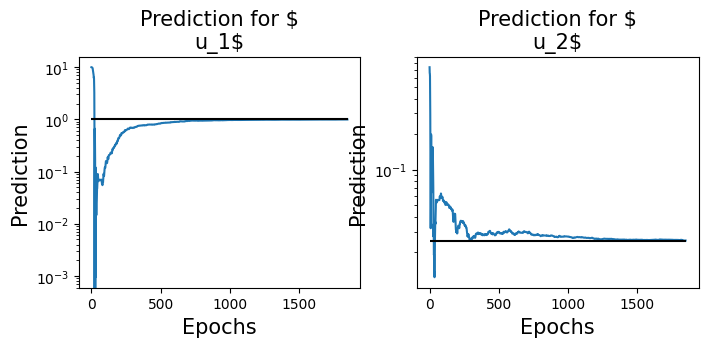

In [18]:
fig = plt.figure(figsize=[8,3])
axes = fig.subplots(1,2, sharex=False, sharey=False)

axes[0].semilogy(model_classic.param_pde_array[0::2])
axes[0].hlines(nu_1_true, xmin=0, xmax=model_classic.epoch, color='black')
axes[0].set_title('Prediction for $\nu_1$', fontsize=15)
axes[0].set_xlabel('Epochs', fontsize=15)
axes[0].set_ylabel('Prediction', fontsize=15)

axes[1].semilogy(model_classic.param_pde_array[1::2])
axes[1].hlines(nu_2_true, xmin=0, xmax=model_classic.epoch, color='black')
axes[1].set_title('Prediction for $\nu_2$', fontsize=15)
axes[1].set_xlabel('Epochs', fontsize=15)
axes[1].set_ylabel('Prediction', fontsize=15)

#### Visualize the cost function

Text(0.5, 1.0, 'Cost function')

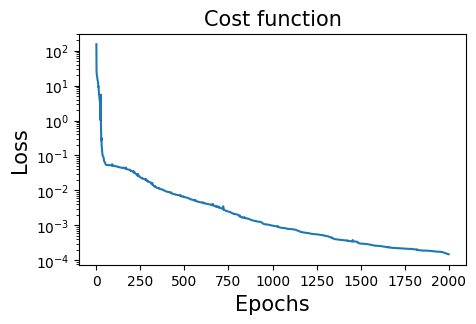

In [19]:
fig = plt.figure(figsize=[5,3])
plt.semilogy(model_classic.loss_array)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.title('Cost function', fontsize=15)

### <font color='red'>**2.2. Exercise:** </font> Linear elascitity <a name="2.2-bullet"></a>

We consider a linear elasticity problem, which we dispose of the solution of the displacement. However, the material parameters: Young'modulus and the Poisson's ratio are unknown. We aim to identity these parameters, which is equivalent to identify the Lamé constant.

The following example comes from [Haghighat et al.(2021)](https://www.sciencedirect.com/science/article/abs/pii/S0045782521000773)

Let us consider a square of lenght $L=1$. The object is subjected to the boundary conditions depicted as figure below:

<img src='https://raw.githubusercontent.com/nguyenkhoa0209/pinns_tutorial/main/image/config_linear_elasiticity_square.png' width="700" height="400">

where $(u,v)$ denotes the displacement vector ($u$ for horizontal component and $v$ for vertical component).

We suppose that the solution is known (or avaible measurements/supervised points), and is calculated as follows:
\begin{align}
u &= \cos(2\pi x)\sin(\pi y)\\
v &= y^4\sin(\pi x)
\end{align}

However, the material parameters: Young'modulus $E$ and the Poisson's ratio $\nu$ are unknown.

The governing PDE for linear elasticity is:
\begin{align}
&-(\lambda+\mu)\nabla (\nabla \boldsymbol{\vec{u}}) - \mu\nabla^2\boldsymbol{\vec{u}}=\boldsymbol{\vec{f}}\\
\Leftrightarrow&\begin{cases}
(\lambda + \mu)(u_{xx}+v_{xy}) + \mu(u_{xx}+u_{yy})+f_x=0\\
(\lambda + \mu)(u_{xy}+v_{yy}) + \mu(v_{xx}+v_{yy})+f_y=0
\end{cases}
\end{align}
where $\boldsymbol{\vec{f}}=(f_x, f_y)$ is the body force, and $\lambda$ and $\mu$ are the Lamé constants, which is defined as:
$$\lambda=\dfrac{E\nu}{(1+\nu)(1-2\nu)} \quad \quad \mu=\dfrac{E}{2(1+\nu)}$$

Thus the identification of $E$ and $\nu$ can be refered as the identification of $\lambda$ and $\mu$.

We will use PINNs to identify the values of $\lambda$ and $\mu$.

#### <font color='red'>**Exercise:** </font> Define the domain and the solution

In [ ]:
## TO IMPLEMENT


# True values of the PDE parameters
lbda_true = 1
mu_true = 0.5

In [ ]:
```{toggle}
# Define the domain
L = 1.0
x = np.linspace(0, L, 100).reshape(-1, 1)
y = np.linspace(0, L, 100).reshape(-1, 1)

X,Y = np.meshgrid(x,y)
X_star = np.concatenate((X.flatten().reshape(-1,1), Y.flatten().reshape(-1,1)), axis=1)

# Define the solution
u_star = np.cos(2*pi*X_star[:, 0:1])*np.sin(pi*X_star[:, 1:2])
v_star = X_star[:, 1:2]**4*np.sin(pi*X_star[:, 0:1])

U_star = np.concatenate((u_star, v_star), axis=1)

# True values of the PDE parameters
lbda_true = 1
mu_true = 0.5
```

#### Defined the training points

To reduce the computational cost, we suppose that only $N_{data}=2000$ availble measurements for the solution.

In [ ]:
# Define training supervised points
N_data = 2000
idx_data = np.random.choice(X_star.shape[0], N_data, replace=False)
X_data = X_star[idx_data]
U_data = U_star[idx_data]

# Define training collocation points
# We can define the collocation points randomly inside the domain
# Here we consider the supervised points as the collocation points
X_colloc_train = X_data

# Initialize the unknown parameters
lbda_init = 2
mu_init = 2
param_pde_init = np.array([lbda_init, mu_init])

#### <font color='red'>**Exercise:** </font> Define PDE residuals and loss term for the PDE

In [ ]:
def net_transform(X_f, model_nn):
    ## TO IMPLEMENT
    return ...

def f_user(X_f, model_nn, param_pde):
    x_temp = X_f[:, 0:1]
    y_temp = X_f[:, 1:2]

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x_temp)
        tape.watch(y_temp)
        X_temp = tf.concat([x_temp, y_temp], axis=1)

        pred = net_transform(X_temp, model_nn)
        u = pred[:, 0:1]
        v = pred[:, 1:2]

        ## TO IMPLEMENT

    return ...

def loss_f(f):
    return ... ## TO IMPLEMENT

In [ ]:
```{toggle}
def net_transform(X_f, model_nn):
    u = model_nn(X_f)[:, 0:1]#* X_f[:, 1:2]*(1-X_f[:, 1:2]) ## optional
    v = model_nn(X_f)[:, 1:2]#* X_f[:, 0:1]*(1-X_f[:, 0:1])* X_f[:, 1:2] ## optional
    return tf.concat([u, v], axis=1)

def f_user(X_f, model_nn, param_pde):
    x_temp = X_f[:, 0:1]
    y_temp = X_f[:, 1:2]

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x_temp)
        tape.watch(y_temp)
        X_temp = tf.concat([x_temp, y_temp], axis=1)

        pred = net_transform(X_temp, model_nn)
        u = pred[:, 0:1]
        v = pred[:, 1:2]

        u_x = tape.gradient(u, x_temp)
        u_y = tape.gradient(u, y_temp)
        v_x = tape.gradient(v, x_temp)
        v_y = tape.gradient(v, y_temp)

        u_xx = tape.gradient(u_x, x_temp)
        u_xy = tape.gradient(u_x, y_temp)
        u_yy = tape.gradient(u_y, y_temp)

        v_xx = tape.gradient(v_x, x_temp)
        v_xy = tape.gradient(v_x, y_temp)
        v_yy = tape.gradient(v_y, y_temp)

    x = x_temp
    y = y_temp

    f_body_x = 17/2*pi**2*tf.math.cos(2*pi*x)*tf.math.sin(pi*y)-6*pi*tf.math.cos(pi*x)*y**3
    f_body_y = -24*tf.math.sin(pi*x)*y**2 + 3*pi**2*tf.math.sin(2*pi*x)*tf.math.cos(pi*y)+0.5*pi**2*y**4*tf.math.sin(pi*x)

    f_x = (param_pde[0]+param_pde[1])*(u_xx+v_xy) + param_pde[1]*(u_xx+u_yy) + f_body_x
    f_y = (param_pde[0]+param_pde[1])*(u_xy+v_yy) + param_pde[1]*(v_xx+v_yy) + f_body_y

    return f_x, f_y

def loss_f(f):
    return tf.reduce_mean(tf.square(f[0])) + tf.reduce_mean(tf.square(f[1]))
```

#### <font color='red'>**Exercise:** </font> Define PINNs architecture

In [ ]:
# Depth and width of the neural networks
layers = ## TO IMPLEMENT

# Learning rate for Adam optimizer
lr =  ## TO IMPLEMENT

In [ ]:
```{toggle}
# Depth and width of the neural networks
layers = [2] + [50]*4 + [2]

# Learning rate for Adam optimizer
lr = 0.001
```

#### <font color='red'>**Exercise:** </font> Train PINNs

In [ ]:
model_classic = PINNs(...) ## TO IMPLEMENT
model_classic.train(max_epochs_adam=..., max_epochs_lbfgs=..., print_per_epochs=100) ## TO IMPLEMENT

In [ ]:
```{toggle}
# networks = FNN(layers, activation, kernel_initializer)
model_classic = PINNs(X_colloc_train, net_transform, f_user, loss_f,
                          layers, lr,param_pde = param_pde_init, type_problem='inverse', X_data = X_data, u_data = U_data)

model_classic.train(max_epochs_adam=0, max_epochs_lbfgs=10000, print_per_epochs=100)
```

### Visualize the results

In [ ]:
fig = plt.figure(figsize=[10,4])
axes = fig.subplots(1,2, sharex=False, sharey=False)

axes[0].semilogy(model_classic.param_pde_array[0::2])
axes[0].hlines(lbda_true, xmin=0, xmax=model_classic.epoch, color='black')
axes[0].set_title('Prediction for $\nu_1$', fontsize=15)
axes[0].set_xlabel('Epochs', fontsize=15)
axes[0].set_ylabel('Prediction', fontsize=15)

axes[1].semilogy(model_classic.param_pde_array[1::2])
axes[1].hlines(mu_true, xmin=0, xmax=model_classic.epoch, color='black')
axes[1].set_title('Prediction for $\nu_2$', fontsize=15)
axes[1].set_xlabel('Epochs', fontsize=15)
axes[1].set_ylabel('Prediction', fontsize=15)

## 3. Ill-posed problem <a name="3-bullet"></a>
In ill-posed problems, the measurements of a partial solution are available, but not the complete solution. We aim at infer the solution for all physical components in the entire domain.

### Example: Navier-Stokes equation <a name="2.1-bullet"></a>
(The data and equations in this example are taken from Raissi et al. (2020) Hidden fluid mechanic)

We consider the following transport equation:
\begin{align}
  c_t + uc_x + vc_y = Pe^{-1}(c_xx + c_yy)
\end{align}
which governs the evolution of the concentration $c(t,x,y)$ of a passive scalar transported by an incompressible Newtonian fluid which are described by the following Navier-Stokes and continuity equations:
 \begin{align}
  u_t + uu_x+vu_y - Re^{-1}(u_{xx}+u_{yy}) + p_x = 0\\
  v_t + uv_x+vv_y - Re^{-1}(v_{xx}+v_{yy}) + p_y = 0\\
  u_x + v_y = 0
\end{align}
where $u,v$ are the components of the velocity field and $p$ is the pressure,  $Re$ and $Pe$ are the Reynold and Péclet number, which are dimensionless.

Here we suppose that only measurements for the concentration $c$ of a passive scalar are available. We aim at infering the laten quantities $u,v$ and $p$. We denote $(\hat{u}, \hat{v}, \hat{p}, \hat{c})=\mathcal{NN}(\boldsymbol{\mathrm{x}}, t, \boldsymbol{\theta})$ the prediction of PINNs for the solution of. The loss function, which includes the loss for the availble measurement for $c$ and the velocity at the inlet, and the loss for the PDE residuals, now becomes:
\begin{align}
  L &= L_{pde} + L_{data_c}+ L_{data_{inlet}}\\
    &= \dfrac{1}{N_{pde}}\sum_{i=1}^{N_{pde}}|\hat{c}^i_t + \hat{u}^i\hat{c}^i_x + \hat{v}^i\hat{c}^i_y - Pe^{-1}(\hat{c}^i_xx + \hat{c}^i_yy)|^2 \\
    &+ \dfrac{1}{N_{pde}}\sum_{i=1}^{N_{pde}}|\hat{u}^i_t + \hat{u}^i\hat{u}^i_x+\hat{v}^i\hat{u}^i_y - Re^{-1}(\hat{u}^i_{xx}+\hat{u}^i_{yy}) + \hat{p}^i_x|^2\\
    &+ \dfrac{1}{N_{pde}}\sum_{i=1}^{N_{pde}}|\hat{v}^i_t + \hat{u}^i\hat{v}^i_x+\hat{v}^i\hat{v}^i_y - Re^{-1}(\hat{v}^i_{xx}+\hat{v}^i_{yy}) + \hat{p}^i_y|^2\\
    &+ \dfrac{1}{N_{pde}}\sum_{i=1}^{N_{pde}}|\hat{u}^i_x + \hat{v}^i_y|^2\\
    &+ \dfrac{1}{N_{c}}\sum_{i=1}^{N_{c}}|\hat{c}^i - c^i|^2\\
    &+ \dfrac{1}{N_{inlet}}\sum_{i=1}^{N_{inlet}}\big(|\hat{u}^i - u^i|^2 + |\hat{v}^i - v^i|^2 \big)
\end{align}


#### Define the domain and reference solution

In [ ]:
X_star = np.load('./data/Cylinder2D_small_X_star.npy')
sol_star = np.load('./data/Cylinder2D_small_sol_star.npy')

#### Define the training points

For the training supervised points, we construct a matrix of size $(N_{data},4)$, whose columns represents for each physical field. As we only dispose of the measurements for the concentration $c$, we fill this matrix by the values of $N_{data}$ measurements for $c$, and for the other field, we fill as **None**.

| u| v | p | c |
| :- | -: | -: |-:
| None | None | None | $c_1$
| None | None | None | $c_2$
| ... | ... | ... | ...
| None | None | None | $c_{N_{data}}$

However, only the concentration $c$ inside the domain is not sufficient to result in a unique velocity field. Therefore, we have to add the supervised points for the velocity $(u,v)$ at the inlet.

In [ ]:
# Training data points
N_data = 10000
idx_data = np.random.choice(X_star.shape[0], N_data, replace=False)
X_data = X_star[idx_data]
u_data = np.array([None]*X_data.shape[0]).reshape(-1,1)
v_data = np.array([None]*X_data.shape[0]).reshape(-1,1)
p_data = np.array([None]*X_data.shape[0]).reshape(-1,1)
c_data = sol_star[idx_data, 3:4]
sol_data = np.concatenate((u_data, v_data, p_data, c_data), axis=1)

# Training points for the velocity at the inlet
idx_inlet = np.where(X_star[:, 0]==-1.0)[0]
X_inlet = X_star[idx_inlet]
sol_inlet = sol_star[idx_inlet]
sol_inlet[:, 2] = np.array([None]*X_inlet.shape[0])
sol_inlet[:, 3] = np.array([None]*X_inlet.shape[0])

# Training collocation points
N_colloc = 10000
idx_colloc = np.random.choice(X_star.shape[0], N_colloc, replace=False)
X_colloc = X_star[idx_colloc]
X_colloc_train = np.concatenate((X_colloc, X_data, X_inlet), axis=0)

# Define the PDE parameters
Pe = 100
Re = 100

In [ ]:
index_t = np.where(X_star[:, -1]==0)
plt.scatter(X_star[index_t, 0], X_star[index_t, 1], c=sol_star[index_t, -1], vmax=1, vmin=0)
plt.plot(X_inlet[:, 0], X_inlet[:, 1], "*", markersize=2, color='black')
plt.colorbar()
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.title('Concentration $c$ at $t=0$ and \n supervised data for at the inlet', fontsize=15)
plt.show()

#### Define PDE residuals and loss term for the PDE

In [ ]:
def net_transform(X_f, model_nn):
    return model_nn(X_f)


def f_user(X_f, model_nn):
    x_temp = X_f[:, 0:1]
    y_temp = X_f[:, 1:2]
    t_temp = X_f[:, 2:3]
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x_temp)
        tape.watch(y_temp)
        tape.watch(t_temp)

        X_temp = tf.concat([x_temp,y_temp, t_temp], axis=1)
        pred = net_transform(X_temp, model_nn)
        u = pred[:, 0:1]
        v = pred[:, 1:2]
        p = pred[:, 2:3]
        c = pred[:, 3:4]

        u_t = tape.gradient(u, t_temp)
        v_t = tape.gradient(v, t_temp)
        c_t = tape.gradient(c, t_temp)

        u_x = tape.gradient(u, x_temp)
        v_x = tape.gradient(v, x_temp)
        p_x = tape.gradient(p, x_temp)
        c_x = tape.gradient(c, x_temp)

        u_y = tape.gradient(u, y_temp)
        v_y = tape.gradient(v, y_temp)
        p_y = tape.gradient(p, y_temp)
        c_y = tape.gradient(c, y_temp)

        u_xx = tape.gradient(u_x, x_temp)
        v_xx = tape.gradient(v_x, x_temp)
        c_xx = tape.gradient(c_x, x_temp)

        u_yy = tape.gradient(u_y, y_temp)
        v_yy = tape.gradient(v_y, y_temp)
        c_yy = tape.gradient(c_y, y_temp)

        f_1 = c_t + (u*c_x + v*c_y) - (1.0/Pe)*(c_xx + c_yy)
        f_2 = u_t + (u*u_x + v*u_y) + p_x - (1.0/Re)*(u_xx + u_yy)
        f_3 = v_t + (u*v_x + v*v_y) + p_y - (1.0/Re)*(v_xx + v_yy)
        f_4 = u_x + v_y

    return f_1, f_2, f_3, f_4

def loss_f(f):
    return tf.reduce_mean(tf.square(f[0])) + tf.reduce_mean(tf.square(f[1]))+ tf.reduce_mean(tf.square(f[2]))+ tf.reduce_mean(tf.square(f[3]))

#### Define PINNs architecture

In [ ]:
# Depth and width of the neural networks
layers = [2] + [50]*4 + [2]

# Learning rate for Adam optimizer
lr = 0.001

#### Train PINNs

In [ ]:
model_classic = PINNs(X_colloc_train, net_transform, f_user, loss_f,
                          layers, lr,type_problem='ill-posed',X_data=X_data, u_data=sol_data, X_other=X_inlet, u_other=sol_inlet)

model_classic.train(max_epochs_adam=5000, max_epochs_lbfgs=1000, print_per_epochs=10)

#### Visualize the results

In [ ]:
pred = model_classic.net_transform(tf.convert_to_tensor(X_star, dtype='float64'), model_classic.net_u)

index_t = np.where(XYT_star_small[:, -1]==1.04)
fig = plt.figure(figsize=[10,4])
axes = fig.subplots(1,2, sharex=False, sharey=False)

axes[0].scatter(X_star[index_t, 0], X_star[index_t, 1], c=sol_star[index_t, 0], vmax=1, vmin=0)
axes[0].set_title('Ref. solution for $u$', fontsize=15)
axes[0].set_xlabel('x', fontsize=15)
axes[0].set_ylabel('y', fontsize=15)

axes[1].scatter(X_star[index_t, 0], X_star[index_t, 1], c=pred[index_t, 0], vmax=1, vmin=0)
axes[1].set_title('Prediction for $u$', fontsize=15)
axes[1].set_xlabel('x', fontsize=15)
axes[1].set_ylabel('y', fontsize=15)

axes[1].scatter(X_star[index_t, 0], X_star[index_t, 1], c=np.abs(sol_star[index_t, 0]-pred[index_t, 0].numpy()), vmax=1, vmin=0)
axes[1].set_title('Error for $u$', fontsize=15)
axes[1].set_xlabel('x', fontsize=15)
axes[1].set_ylabel('y', fontsize=15)

## 4. Generalization problem <a name="4-bullet"></a>
In generalization problem, we aim at infer the solution for different values PDE parameters in one model. In this case, the PDE parameters are also considered as an input of PINNs, i.e. the network in PINNs is represented as $\mathcal{NN}(\boldsymbol{\mathrm{x}}, t, \lambda)$, where $\lambda$ denotes the PDE parameters.

### 4.1. Example: Burgers equation <a name="4.1-bullet"></a>
We consider the following Burgers equation:
\begin{align}
  &u_t + uu_x -\nu u_{xx} = 0 \quad \text{for } x\in [-1,1], t\in[0, 1] \\
  &u(x,0) = -\sin(\pi x) \quad \text{for } x\in [-1,1]\\
  &u(-1,t) = u(1,t) = 0 \quad \text{for } t\in [0,1]
\end{align}

where $\nu$ is the PDE parameter. In this example, we take $N_{\nu}$ values of $\nu\in[0.0025,0.0124]$.

If we force the IC/BC to be satisfied automatically, the loss now includes only the loss for PDE residuals:
\begin{align}
L &= \sum_{j=1}^{N_{\nu}}L_{pde}^j\\
    &= \sum_{j=1}^{N_{\nu}} \dfrac{1}{N_{pde}^j}\sum_{i=1}^{N_{pde}^j}|\hat{u}^{i,j}_{t} + \hat{u}^{i,j}\hat{u}^{i,j}_{x} -\nu \hat{u}^{i,j}_{xx}|^2  
\end{align}

#### Define the domain

In [ ]:
nx = 256
nt = 100
x = np.linspace(-1, 1, nx)
t = np.linspace(0, 1, nt)
X, T = np.meshgrid(x,t)

X_star_xt = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

nu_array = np.linspace(0,0.025,100).reshape(-1,1)
nu_star = nu_array[10:50]

X_star = np.concatenate((np.tile(X_star_xt, (nu_star.shape[0],1)),
                                       np.repeat(nu_star, X_star_xt.shape[0]).reshape(-1,1)), axis=1)

#### Define the IC/BC, and training points

Again in this case, we will force the IC and BC to be satisfied automatically. We only then need to define the collocation points.

In [ ]:
# Define training collocation points
N_f = 2000
idx_Xf = np.random.choice(X_star_xt.shape[0], N_f, replace=False)
X_colloc_xt = X_star_xt[idx_Xf]

X_colloc_train = np.concatenate((np.tile(X_colloc_xt, (nu_star.shape[0],1)),
                                       np.repeat(nu_star, X_colloc_xt.shape[0]).reshape(-1,1)), axis=1)

#### Define PDE residuals and loss term for the PDE

In [ ]:
def net_transform(X_f, model_nn):
    return model_nn(X_f)[:, 0:1] * X_f[:, 1:2] * (X_f[:, 0:1] + 1) * (X_f[:, 0:1] - 1) - tf.math.sin(pi * X_f[:, 0:1])

def f_user(X_f, model_nn):
    x_temp = X_f[:, 0:1]
    t_temp = X_f[:, 1:2]
    nu_temp = X_f[:, 2:3]
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x_temp)
        tape.watch(t_temp)
        X_temp = tf.concat([x_temp, t_temp, nu_temp], axis=1)

        u = net_transform(X_temp, model_nn)
        u_x = tape.gradient(u, x_temp)
        u_xx = tape.gradient(u_x, x_temp)
        u_t = tape.gradient(u, t_temp)

    f = u_t + u * u_x - nu_temp * u_xx
    return f

def loss_f(f):
    return tf.reduce_mean(tf.square(f))

#### PINNs architecture

In [ ]:
# Depth and width of the neural networks
layers = [3] + [50]*4 + [1]

# Learning rate for Adam optimizer
lr = 0.001

#### Train PINNs

In [ ]:
model_classic = PINNs(X_colloc_train, net_transform, f_user, loss_f,
                          layers, lr,type_problem='generalization')

model_classic.train(max_epochs_adam=5000, max_epochs_lbfgs=0, print_per_epochs=100)

#### Visualize the results

### <font color='red'>**4.2. Exercise:** </font> Wave equation <a name="4.2-bullet"></a>
We consider the following 1D wave equation, which is similar to the wave equation considered in \cite{peng2022rang}:
\begin{align*}
\begin{cases}
  u_{tt} + c^2u_{xx} = 0 \quad \text{for } x\in [-l,l], t\in[0, T] \\
  u(x,0) = \dfrac{1}{\cosh(2x)} - \dfrac{1}{2\cosh(2(x-2l))}+\dfrac{1}{2\cosh(2(x+2l))}\\
  u(-l,t) = u(l,t) = 0\\
  u_t(x,0) = 0
\end{cases}
\end{align*}
with $l=4$ and $T=5.5$. The exact solution is given as:
\begin{align*}
    u(x,t) = \dfrac{1}{2\cosh(2(x+ct))} - \dfrac{1}{2\cosh(2(x-2l+ct))} + \dfrac{1}{2\cosh(2(x-ct))} - \dfrac{1}{2\cosh(2(x+2l-ct))}
\end{align*}

In this case, $k=c^2$ is the PDE paramter of interest. It is also considered as an input of PINNs. For the training, we take $41$ values of $\nu\in[1,3]$ for $k$.

#### Define the domain

In [ ]:
l = 4
T = 5.5
nx = 256
nt = 100
x = np.linspace(-l, l, nx)
t = np.linspace(0, T, nt)
X, T = np.meshgrid(x, t)

X_star_xt = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

k_array = np.arange(0.7, 3.2, 0.05)[6:-3]

X_star = np.concatenate((np.tile(X_star_xt, (k_array.shape[0],1)),
                                       np.repeat(k_array, X_star_xt.shape[0]).reshape(-1,1)), axis=1)

#### Define the IC/BC, and training points

Again in this case, we will force the IC and Dirichlet BC to be satisfied automatically. We then need to define the collocation points and the training points for the Neumann BC.

In [ ]:
# Define training collocation points
N_f = 2000
idx_Xf = np.random.choice(X_star_xt.shape[0], N_f, replace=False)
X_colloc_xt = X_star_xt[idx_Xf]

X_colloc_train = np.concatenate((np.tile(X_colloc_xt, (k_array.shape[0],1)),
                                       np.repeat(k_array, X_colloc_xt.shape[0]).reshape(-1,1)), axis=1)

# Define the training Neumann BC
idx_bc = np.where(X_star_xt[:, 1]==0.0)[0]
X_bc_xt = X_star_xt[idx_bc]

X_bc_neu = np.concatenate((np.tile(X_bc_xt, (k_array.shape[0],1)),
                                       np.repeat(k_array, X_bc_xt.shape[0]).reshape(-1,1)), axis=1)

We also need define the Neumann condition:

In [ ]:
def dt_condition(X_neu, model_nn):
    x_temp = X_neu[:, 0:1]
    t_temp = X_neu[:, 1:2]
    k_temp = X_neu[:, 2:3]
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x_temp)
        tape.watch(t_temp)
        X_temp = tf.concat([x_temp, t_temp, k_temp], axis=1)

        u = net_transform(X_temp, model_nn)[:, 0:1]
        u_t = tape.gradient(u, t_temp)

    return u_t

#### <font color='red'>Exercise: </font> Define the PDE residuals and the loss term for the PDE

In [ ]:
def net_transform(X_f, model_nn):
    return ...

def f_user(X_f, model_nn):
    x_temp = X_f[:, 0:1]
    t_temp = X_f[:, 1:2]
    k_temp = X_f[:, 2:3]
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x_temp)
        tape.watch(t_temp)
        X_temp = tf.concat([x_temp, t_temp, k_temp], axis=1)

        u = net_transform(X_temp, model_nn)

        # TO IMPLEMENT
    return ...

def loss_f(f):
    # TO IMPLEMENT
    return ...

In [ ]:
```{toggle}
def net_transform(X_f, model_nn):
    return model_nn(X_f)[:, 0:1] * X_f[:, 1:2] * (X_f[:, 0:1] + l) * (X_f[:, 0:1] - l) - 1/tf.math.cosh(2 * (X_star_xt[:, 0:1])) + 0.5*1/tf.math.cosh(2 * (X_star_xt[:, 0:1])-4*l)- 0.5*1/tf.math.cosh(2 * (X_star_xt[:, 0:1])+4*l)

def f_user(X_f, model_nn):
    x_temp = X_f[:, 0:1]
    t_temp = X_f[:, 1:2]
    k_temp = X_f[:, 2:3]
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x_temp)
        tape.watch(t_temp)
        X_temp = tf.concat([x_temp, t_temp, t_temp], axis=1)

        u = net_transform(X_temp, model_nn)[:, 0:1]
        u_x = tape.gradient(u, x_temp)
        u_xx = tape.gradient(u_x, x_temp)
        u_t = tape.gradient(u, t_temp)
        u_tt = tape.gradient(u_t, t_temp)

    f = u_tt - k_temp * u_xx
    return f

def loss_f(f):
    return tf.reduce_mean(tf.square(f))
```{toggle}

#### PINNs architecture

In [ ]:
# Depth and width of the neural networks
layers = [3] + [50]*4 + [1]

# Learning rate for Adam optimizer
lr = 0.001

#### Train PINNs

In [ ]:
model_classic = PINNs(X_colloc_train, net_transform, f_user, loss_f,
                          layers, lr,type_problem='generalization', X_other=X_bc_neu, u_other=u_bc_neu, net_other=dt_condition)

model_classic.train(max_epochs_adam=5000, max_epochs_lbfgs=100, print_per_epochs=100, )

#### Visualize the results